In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline


In [2]:
labels_path = "../data/raw/labels.csv"
df = pd.read_csv(labels_path)

df.head()


,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


In [3]:
print("Total samples:", len(df))
print("Unique classes:", df["diagnosis"].unique())


Total samples: 2930
Unique classes: [2 1 4 0 3]


diagnosis
0    1434
1     300
2     808
3     154
4     234
Name: count, dtype: int64


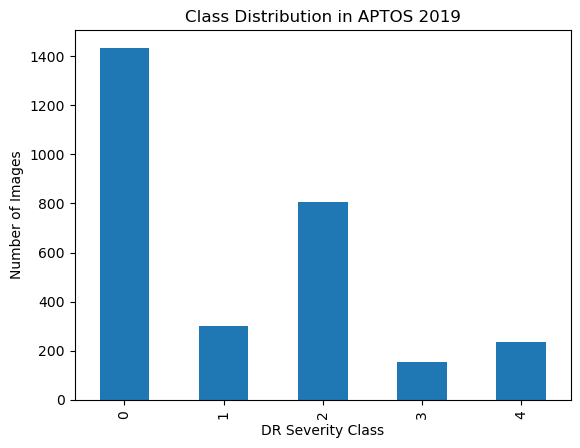

In [4]:
class_counts = df["diagnosis"].value_counts().sort_index()
print(class_counts)

class_counts.plot(kind="bar")
plt.xlabel("DR Severity Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in APTOS 2019")
plt.show()


In [5]:
image_dir = "../data/raw/images"

missing = []
for img_id in df["id_code"]:
    img_path = os.path.join(image_dir, img_id + ".png")
    if not os.path.exists(img_path):
        missing.append(img_id)

print("Missing images:", len(missing))


Missing images: 12


In [6]:
print("IDs with missing images:")
missing[:20]  # show first few


IDs with missing images:


['2.3255E+11',
 '2.93E+10',
 '3.89552E+11',
 '4.41118E+11',
 '5.35683E+11',
 '5.49381E+11',
 '5.95447E+11',
 '7.21214E+11',
 '8.91E+20',
 '9.21433E+11',
 '9.34E+76',
 '9.46545E+11']

In [7]:
print("Before cleaning:", len(df))

df = df[~df["id_code"].isin(missing)].reset_index(drop=True)

print("After cleaning:", len(df))


Before cleaning: 2930
After cleaning: 2918


In [8]:
missing = []
for img_id in df["id_code"]:
    img_path = os.path.join(image_dir, img_id + ".png")
    if not os.path.exists(img_path):
        missing.append(img_id)

print("Missing images:", len(missing))


Missing images: 0


In [9]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["diagnosis"],
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))


Train size: 2334
Validation size: 584


In [10]:
print("Train class distribution:")
print(train_df["diagnosis"].value_counts().sort_index())

print("\nValidation class distribution:")
print(val_df["diagnosis"].value_counts().sort_index())


Train class distribution:
diagnosis
0    1141
1     239
2     644
3     123
4     187
Name: count, dtype: int64

Validation class distribution:
diagnosis
0    285
1     60
2    161
3     31
4     47
Name: count, dtype: int64


In [11]:
split_dir = "../data/processed"
os.makedirs(split_dir, exist_ok=True)

train_df.to_csv(os.path.join(split_dir, "train.csv"), index=False)
val_df.to_csv(os.path.join(split_dir, "val.csv"), index=False)

print("Splits saved to data/processed/")


Splits saved to data/processed/


In [12]:
%pip install torchvision
import torch
from torchvision import transforms


Note: you may need to restart the kernel to use updated packages.


In [13]:
import torch
from torchvision import transforms


In [14]:
IMAGE_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [15]:
sample_row = train_df.sample(1).iloc[0]
img_path = os.path.join(image_dir, sample_row["id_code"] + ".png")

img = Image.open(img_path).convert("RGB")
tensor_img = train_transforms(img)

print("Tensor shape:", tensor_img.shape)
print("Min value:", tensor_img.min().item())
print("Max value:", tensor_img.max().item())


Tensor shape: torch.Size([3, 224, 224])
Min value: -2.1179039478302
Max value: 2.248908281326294


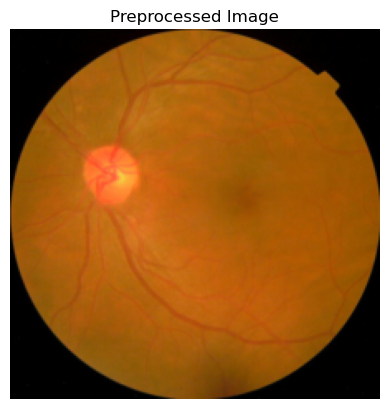

In [16]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return tensor * std + mean

plt.imshow(denormalize(tensor_img).permute(1,2,0))
plt.axis("off")
plt.title("Preprocessed Image")
plt.show()


In [17]:
from torch.utils.data import DataLoader
import sys
sys.path.append("../")
from src.dataset import DiabeticRetinopathyDataset

In [18]:
train_csv = "../data/processed/train.csv"
val_csv = "../data/processed/val.csv"
image_dir = "../data/raw/images"

train_dataset = DiabeticRetinopathyDataset(
    csv_file=train_csv,
    image_dir=image_dir,
    transform=train_transforms
)

val_dataset = DiabeticRetinopathyDataset(
    csv_file=val_csv,
    image_dir=image_dir,
    transform=val_transforms
)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))


Train samples: 2334
Val samples: 584


In [19]:
BATCH_SIZE = 16  # HP Victus safe starting point

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [20]:
images, labels = next(iter(train_loader))

print("Batch image shape:", images.shape)
print("Batch label shape:", labels.shape)
print("Labels:", labels)


c:\Users\HP\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch image shape: torch.Size([16, 3, 224, 224])
Batch label shape: torch.Size([16])
Labels: tensor([0, 2, 0, 2, 2, 2, 3, 1, 0, 0, 2, 0, 0, 2, 2, 0])


In [21]:
import torch
from src.model import DRResNet50

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = DRResNet50(num_classes=5, pretrained=True)
model = model.to(device)

images, labels = next(iter(train_loader))
images = images.to(device)

outputs = model(images)

print("Output shape:", outputs.shape)


Using device: cpu


c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([16, 5])


In [23]:
import numpy as np
import torch


In [24]:
class_counts = train_df["diagnosis"].value_counts().sort_index()
print(class_counts)

total = class_counts.sum()
class_weights = total / (len(class_counts) * class_counts)

print("Class weights:", class_weights)


diagnosis
0    1141
1     239
2     644
3     123
4     187
Name: count, dtype: int64
Class weights: diagnosis
0    0.409115
1    1.953138
2    0.724845
3    3.795122
4    2.496257
Name: count, dtype: float64


In [25]:
class_weights_tensor = torch.tensor(
    class_weights.values,
    dtype=torch.float
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = class_weights_tensor.to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)


In [26]:
import torch.optim as optim

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)


In [27]:
from sklearn.metrics import accuracy_score, f1_score

In [28]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")

    return avg_loss, acc, f1


C:\Users\HP\AppData\Local\Temp\ipykernel_34188\3284722988.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="diagnosis", data=labels, palette="viridis")


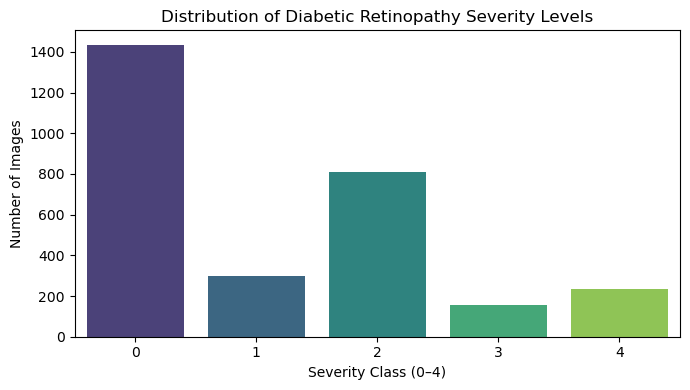

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

labels = pd.read_csv("../data/raw/labels.csv")

plt.figure(figsize=(7,4))
sns.countplot(x="diagnosis", data=labels, palette="viridis")
plt.title("Distribution of Diabetic Retinopathy Severity Levels")
plt.xlabel("Severity Class (0–4)")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


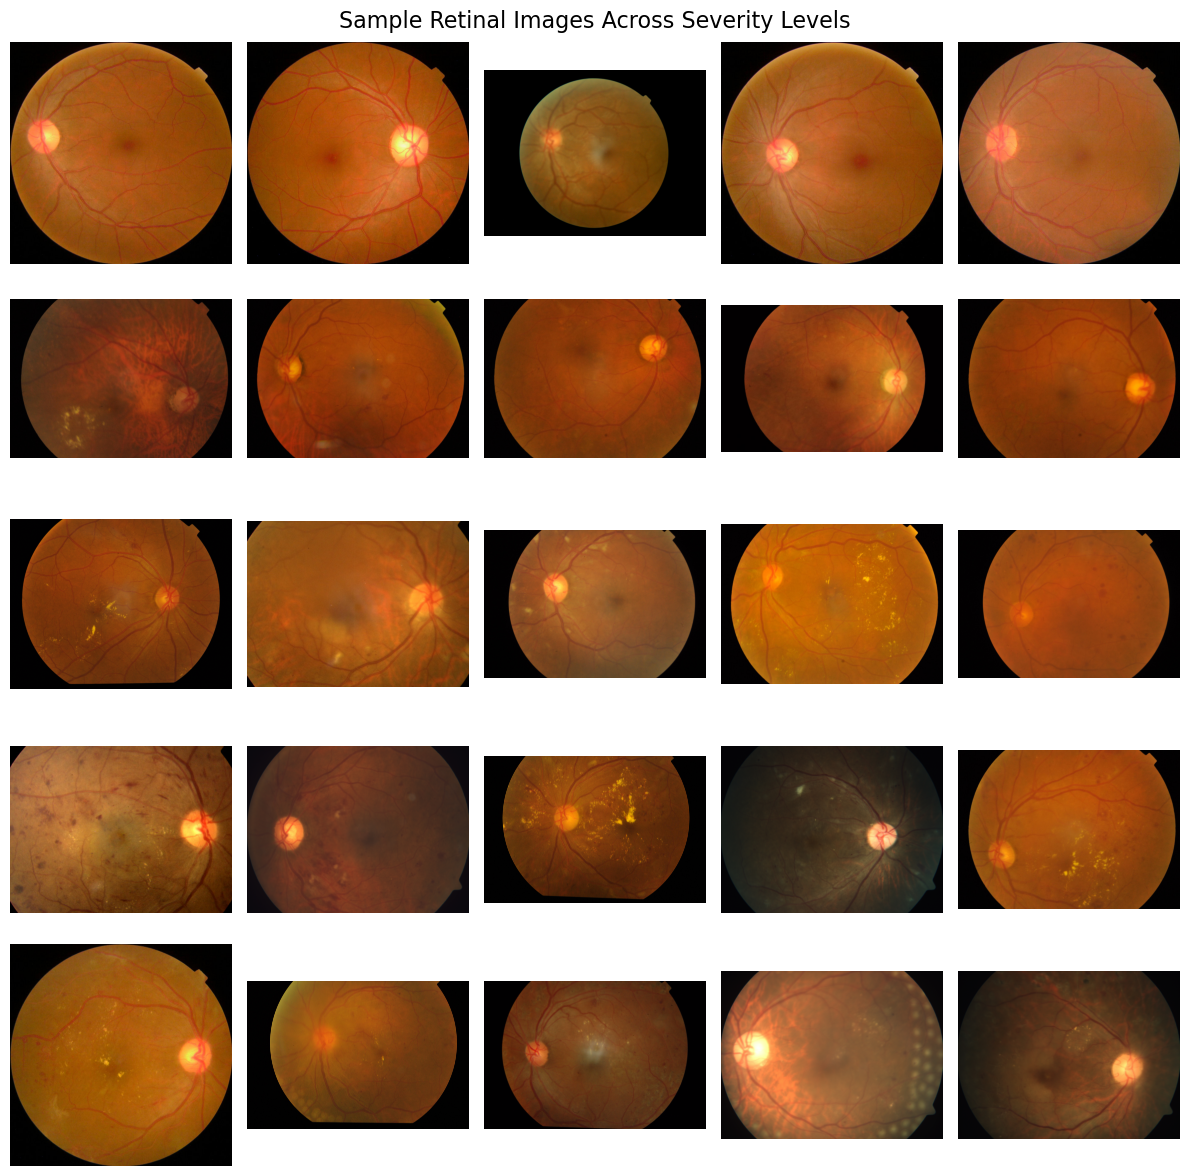

In [30]:
import os
import random
from PIL import Image

image_dir = "../data/raw/images"

fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for cls in range(5):
    cls_images = labels[labels["diagnosis"] == cls]["id_code"].tolist()
    sampled = random.sample(cls_images, 5)

    for i, img_id in enumerate(sampled):
        img_path = os.path.join(image_dir, img_id + ".png")
        img = Image.open(img_path)
        axes[cls, i].imshow(img)
        axes[cls, i].axis("off")
        if i == 0:
            axes[cls, i].set_ylabel(f"Class {cls}", fontsize=12)

plt.suptitle("Sample Retinal Images Across Severity Levels", fontsize=16)
plt.tight_layout()
plt.show()


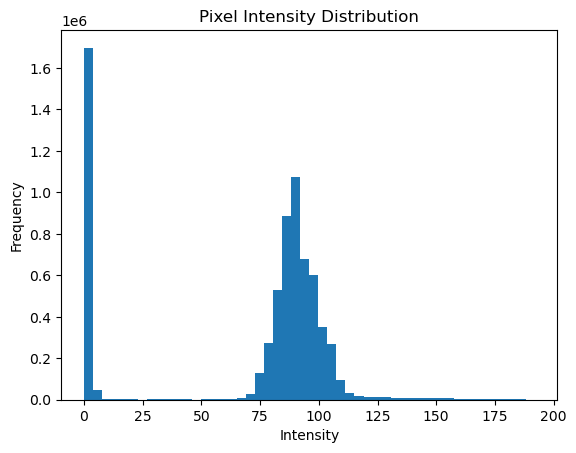

In [31]:
import numpy as np

def show_brightness_contrast(img_path):
    img = np.array(Image.open(img_path).convert("L"))
    plt.hist(img.flatten(), bins=50)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.show()

sample_img = os.path.join(image_dir, labels.iloc[0]["id_code"] + ".png")
show_brightness_contrast(sample_img)
